In [1]:
import cn2an
from opencc import OpenCC
cc = OpenCC('t2s')
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

import csv
import jiwer
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
import os
from joblib import Parallel, delayed
from torch.utils.data import Dataset

import whisper
from whisper.audio import (
    log_mel_spectrogram,
    pad_or_trim,
    load_audio,
)
from suta import *
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import re
import numpy as np
# 開啟文件
with open('./base_no_noise.txt', 'r') as file:
    # 讀取文件所有行
    lines = file.readlines()

# 初始化兩個列表
ori_wers = []
wer_10 = []
ori_transcription = []
transcriptions_10 = []
sentences = []

# 遍歷每一行
for line in lines:
    # 刪除每行開頭和結尾的空白字符
    line = line.strip()
    # 使用":"分割該行，取第二部分作為句子
    try:
        sentence = line.split(':')[1]
    except:
        continue
    # 如果該行以"ori"開頭
    if line.startswith('ori'):
        # 使用":"分割該行，取第二部分作為ori的值
        match = re.search(r'\((.*?)\)', (line.split(':')[0]))
        ori_wer = float(match.group(1))
        # 將ori的值添加到ori_wers列表中
        ori_wers.append(ori_wer)
        ori_transcription.append(sentence)
    # 如果該行以"label"開頭
    elif line.startswith('label'):
        sentences.append(line.split(':')[1])
    elif line.startswith('step19'):
        # 使用":"分割該行，取第二部分作為ori的值
        match = re.search(r'\((.*?)\)', (line.split(':')[0]))
        ori_value = float(match.group(1))
        # 將ori的值添加到ori_values列表中
        wer_10.append(ori_value)
        sentence = line.split(':')[1]
        transcriptions_10.append(sentence)

In [4]:
print(np.array(ori_wers).mean())
print(np.array(wer_10).mean())

0.09694275388684233
0.09687619126964112


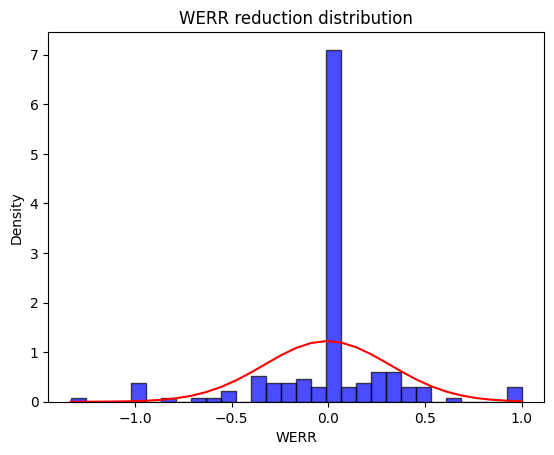

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from whisper.normalizers import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()
werr_list = []
for i in range(len(transcriptions_10)):
    ori_wer = jiwer.wer(normalizer(sentences[i]), normalizer(ori_transcription[i]))
    adapt_wer = jiwer.wer(normalizer(sentences[i]), normalizer(transcriptions_10[i]))
    # if adapt_wer != wer_10[i]:
        # print(adapt_wer, wer_10[i])
    try:
        werr = (ori_wers[i] - wer_10[i])/ori_wers[i]
        # werr = (ori_wer - adapt_wer)/ori_wer
    except:
        if adapt_wer != 0:
        # if wer_10[i] != 0:
            werr = 1
        else:
            werr = 0
    werr_list.append(werr)

# 绘制直方图
plt.hist(werr_list, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('WERR reduction distribution')
plt.xlabel('WERR')
plt.ylabel('Density')

# # 绘制密度估计图
werr_list = np.array(werr_list)
density, bins, _ = plt.hist(werr_list, bins=30, density=True, alpha=0)
plt.plot(bins, 1/(np.sqrt(2*np.pi)*np.std(werr_list)) * np.exp(-0.5*(bins-np.mean(werr_list))**2/np.var(werr_list)), color='red')
plt.title('WERR reduction distribution')
plt.xlabel('WERR')
plt.ylabel('Density')

plt.show()


In [6]:
from whisper.normalizers import EnglishTextNormalizer
import jiwer
normalizer = EnglishTextNormalizer()

def find_different_words(sentence1, sentence2):
    # 分解句子为单词列表
    words1 = set(normalizer(sentence1).split())
    words2 = set(normalizer(sentence2).split())
    
    # 找出不同的单词
    different_words = words2 - words1
    original_words = words1 - words2
    return original_words, different_words

subs = []
inss = []
dels = []
with open('./err_analysis.txt', 'w' ) as f:
    for i in range(len(ori_transcription)):
        result = jiwer.compute_measures(normalizer(ori_transcription[i]), normalizer(transcriptions_10[i]))
        # 打印结果
        print("WERR:", jiwer.wer(normalizer(sentences[i]), normalizer(ori_transcription[i])) - jiwer.wer(normalizer(sentences[i]), normalizer(transcriptions_10[i])), file=f)  # WER表示单词错误率
        print("Substitutions:", result['substitutions'], file=f)  # 替换的单词列表
        print("Insertions:", result['insertions'], file=f)  # 插入的单词列表
        print("Deletions:", result['deletions'], file=f)  # 删除的单词列表
        print(f"label:{sentences[i]}", file=f)
        print(f"original_sentence:{ori_transcription[i]}", file=f)
        print(f"adapted_sentence:{transcriptions_10[i]}", file=f)
        subs.append(result['substitutions'])
        inss.append(result['insertions'])
        dels.append(result['deletions'])
        # print("Ref:", result['alignment']['true'])  # 参考文本中的单词列表
        # print("Hyp:", result['alignment']['pred'])  # 预测文本中的单词列表
        # f.write(sentences[i]+'\n')
        # f.write(normalizer(ori_transcription[i])+'\n')
        # f.write(normalizer(transcriptions_10[i])+'\n')
        f.write(str(find_different_words(ori_transcription[i], transcriptions_10[i]))+'\n')
        f.write('=======================================\n')

In [7]:
print(np.array(subs).mean())
print(np.array(inss).mean())
print(np.array(dels).mean())

0.9941860465116279
0.2558139534883721
0.13953488372093023


In [5]:
data = pd.read_csv('./ex_data/csv/tiny.en_librispeech_2.5_noise_0.01_lr_2e-05_EMcoef_0.3_encoderOnly_None_decoderOnly_decoderOnly_topk_30_beam_2.csv')

In [7]:
from whisper.normalizers import EnglishTextNormalizer
import jiwer
normalizer = EnglishTextNormalizer()

data["before_adapt_clean"] = [normalizer(text) for text in data["before_adapt"]]
data["step1_clean"] = [normalizer(text) for text in data["step1"]]
data["step3_clean"] = [normalizer(text) for text in data["step3"]]
data["step5_clean"] = [normalizer(text) for text in data["step5"]]
data["step10_clean"] = [normalizer(text) for text in data["step10"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]

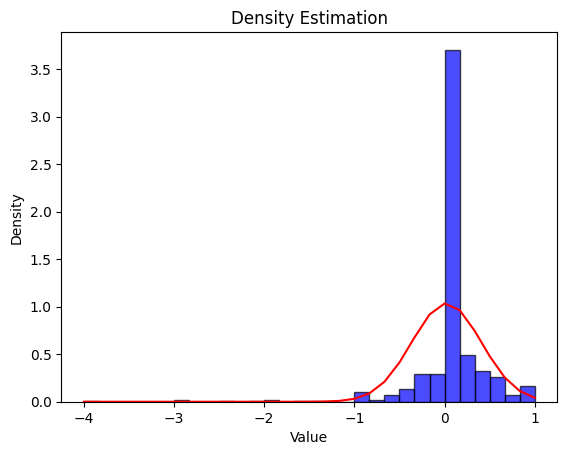

In [23]:
import matplotlib.pyplot as plt
import numpy as np
werr_list = []
for i in range(len(data['step10_clean'])):
    ori_wer = jiwer.wer(data['reference_clean'][i], data['before_adapt_clean'][i])
    adapt_wer = jiwer.wer(data['reference_clean'][i], data['step10_clean'][i])
    try:
        werr = (ori_wer - adapt_wer)/ori_wer
    except:
        if adapt_wer != 0:
            werr = 1
        else:
            werr = 0
    werr_list.append(werr)

# 绘制直方图
plt.hist(werr_list, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 绘制密度估计图
werr_list = np.array(werr_list)
density, bins, _ = plt.hist(werr_list, bins=30, density=True, alpha=0)
plt.plot(bins, 1/(np.sqrt(2*np.pi)*np.std(werr_list)) * np.exp(-0.5*(bins-np.mean(werr_list))**2/np.var(werr_list)), color='red')
plt.title('Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


In [19]:

data["before_adapt_clean"] = [cn2an.transform(cc.convert(text) ,"an2cn") for count, text in enumerate(data["before_adapt"]) ]
data["step1_clean"] = [cn2an.transform(cc.convert(text) ,"an2cn") for count, text in enumerate(data["step1"]) ]
data["step3_clean"] = [cn2an.transform(cc.convert(text) ,"an2cn") for count, text in enumerate(data["step3"]) ]
data["step5_clean"] = [cn2an.transform(cc.convert(text) ,"an2cn") for count, text in enumerate(data["step5"]) ]
data["step10_clean"] = [cn2an.transform(cc.convert(text) ,"an2cn") for count, text in enumerate(data["step10"]) ]

In [24]:
data = data.drop(data.index[1000:])

In [20]:
wer_list = []
wer_list.append(jiwer.cer(list(data["reference"]), list(data["before_adapt"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step1"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step3"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step5"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step10"])))
wer_list

[0.2832350285533367,
 0.28370407720540813,
 0.2835750888260885,
 0.28351645774457956,
 0.2834695528793724]

In [25]:
wer_list = []
wer_list.append(jiwer.cer(list(data["reference"]), list(data["before_adapt_clean"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step1_clean"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step3_clean"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step5_clean"])))
wer_list.append(jiwer.cer(list(data["reference"]), list(data["step10_clean"])))
wer_list

[0.20610687022900764,
 0.20593138545231202,
 0.20610687022900764,
 0.20593138545231202,
 0.20601912784065982]

In [35]:
jiwer.cer(list(data["reference"]), list(data["hypothesis_clean"]))

0.23161260149199947

In [10]:
for ref, pred in zip(list(data["reference"]), list(data["hypothesis"])):
    print(jiwer.cer(ref, pred))

0.4782608695652174
0.125
0.2
0.7777777777777778
0.25
0.25
0.15384615384615385
0.15384615384615385
0.25
0.0
1.0
1.0
1.0
0.375
0.2727272727272727
0.3
0.4
0.6
0.16666666666666666
0.0
0.0
0.0
1.5
1.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.7916666666666666
0.34782608695652173
0.42105263157894735
0.2857142857142857
0.09523809523809523
0.6842105263157895
0.2777777777777778
0.4666666666666667
0.3333333333333333
0.5625
0.05555555555555555
0.5333333333333333
0.2222222222222222
1.0
0.6923076923076923
0.06666666666666667
0.3076923076923077
0.0
0.5454545454545454
0.14285714285714285
0.23076923076923078
0.36363636363636365
0.0
0.36363636363636365
0.0
0.2222222222222222
0.3333333333333333
0.125
0.14285714285714285
0.3333333333333333
1.0
0.0
0.4117647058823529
0.041666666666666664
0.3888888888888889
0.19047619047619047
0.35294117647058826
0.0
0.1111111111111111
0.0
0.35714285714285715
0.5333333333333333
0.0
0.14285714285714285
0.16666666666666666
0.2
0.4444444444444444
0.1
0.23076923076923078
0.1
1.0
0.75
